# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:11<00:00, 5.42KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

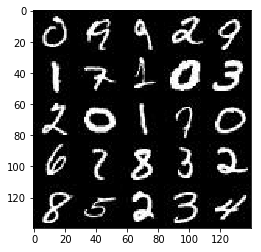

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

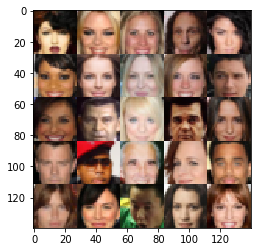

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits        

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 4, strides=1, padding='valid')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now

        x3 = tf.layers.conv2d_transpose(x2, 128, 4, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now

        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 4, strides=2, padding='same')
        # 32x32x3 now

        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [28]:
import os

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):    
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    if not os.path.exists('./checkpoints'):
        os.makedirs('./checkpoints')
    
    # TODO: Build Model
    n, h, w, d = data_shape
    input_real, input_z, learning_rate_ph = model_inputs(h, w, d, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, d)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate_ph, beta1)
    
    samples, losses = [], []
    steps = 0    
    print_every = 10
    show_every = 100
    n_images = 72
    
    saver = tf.train.Saver()    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, 
                                                input_z: batch_z,
                                                learning_rate_ph: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, 
                                                input_real: batch_images,
                                                learning_rate_ph: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                            "Discriminator Loss: {:.4f}...".format(train_loss_d),
                            "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, n_images, input_z, d, data_image_mode)
  
        print('saving generator.ckpt')
        saver.save(sess, './checkpoints/generator.ckpt')                     

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0172... Generator Loss: 5.8970
Epoch 1/2... Discriminator Loss: 0.0065... Generator Loss: 5.4347
Epoch 1/2... Discriminator Loss: 0.0519... Generator Loss: 3.6625
Epoch 1/2... Discriminator Loss: 0.0441... Generator Loss: 3.6575
Epoch 1/2... Discriminator Loss: 0.0114... Generator Loss: 12.5354
Epoch 1/2... Discriminator Loss: 4.6553... Generator Loss: 0.0128
Epoch 1/2... Discriminator Loss: 0.1068... Generator Loss: 2.7829
Epoch 1/2... Discriminator Loss: 0.0044... Generator Loss: 10.7536
Epoch 1/2... Discriminator Loss: 0.0198... Generator Loss: 5.8205
Epoch 1/2... Discriminator Loss: 0.5271... Generator Loss: 2.9538


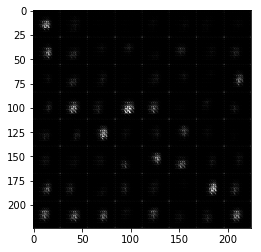

Epoch 1/2... Discriminator Loss: 0.8284... Generator Loss: 2.2501
Epoch 1/2... Discriminator Loss: 0.0523... Generator Loss: 4.5752
Epoch 1/2... Discriminator Loss: 0.7305... Generator Loss: 7.3544
Epoch 1/2... Discriminator Loss: 0.4320... Generator Loss: 2.0628
Epoch 1/2... Discriminator Loss: 0.2000... Generator Loss: 4.1847
Epoch 1/2... Discriminator Loss: 0.0798... Generator Loss: 3.1345
Epoch 1/2... Discriminator Loss: 0.1612... Generator Loss: 2.4811
Epoch 1/2... Discriminator Loss: 0.0957... Generator Loss: 4.0895
Epoch 1/2... Discriminator Loss: 0.2415... Generator Loss: 3.9173
Epoch 1/2... Discriminator Loss: 0.5790... Generator Loss: 0.9896


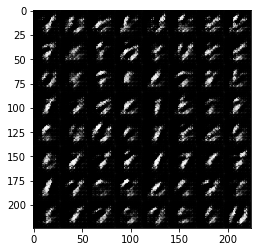

Epoch 1/2... Discriminator Loss: 0.2229... Generator Loss: 2.6776
Epoch 1/2... Discriminator Loss: 0.0542... Generator Loss: 11.1097
Epoch 1/2... Discriminator Loss: 0.0756... Generator Loss: 3.9736
Epoch 1/2... Discriminator Loss: 0.0740... Generator Loss: 3.1286
Epoch 1/2... Discriminator Loss: 0.0281... Generator Loss: 4.0928
Epoch 1/2... Discriminator Loss: 0.0304... Generator Loss: 4.3538
Epoch 1/2... Discriminator Loss: 0.0751... Generator Loss: 3.2309
Epoch 1/2... Discriminator Loss: 0.0583... Generator Loss: 3.3842
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 4.9701
Epoch 1/2... Discriminator Loss: 1.2012... Generator Loss: 0.4774


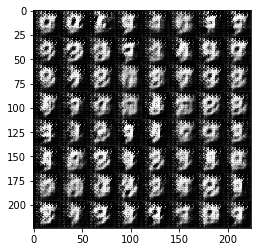

Epoch 1/2... Discriminator Loss: 0.4247... Generator Loss: 1.7390
Epoch 1/2... Discriminator Loss: 0.7074... Generator Loss: 9.5134
Epoch 1/2... Discriminator Loss: 1.4646... Generator Loss: 0.3857
Epoch 1/2... Discriminator Loss: 0.1023... Generator Loss: 3.1061
Epoch 1/2... Discriminator Loss: 0.0153... Generator Loss: 6.7003
Epoch 1/2... Discriminator Loss: 3.3811... Generator Loss: 0.0626
Epoch 1/2... Discriminator Loss: 1.2655... Generator Loss: 0.3932
Epoch 1/2... Discriminator Loss: 0.3906... Generator Loss: 1.9122
Epoch 1/2... Discriminator Loss: 1.9891... Generator Loss: 0.2905
Epoch 1/2... Discriminator Loss: 1.6047... Generator Loss: 0.3437


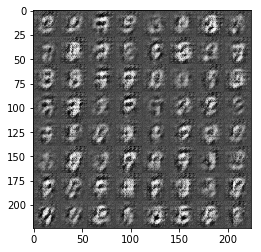

Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 1.7644
Epoch 1/2... Discriminator Loss: 0.6209... Generator Loss: 2.4062
Epoch 1/2... Discriminator Loss: 0.2782... Generator Loss: 2.5429
Epoch 1/2... Discriminator Loss: 0.3726... Generator Loss: 2.3386
Epoch 1/2... Discriminator Loss: 0.3410... Generator Loss: 1.6261
Epoch 1/2... Discriminator Loss: 0.7230... Generator Loss: 3.2330
Epoch 1/2... Discriminator Loss: 0.6780... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 0.6514... Generator Loss: 0.9452
Epoch 1/2... Discriminator Loss: 1.3838... Generator Loss: 0.5639
Epoch 1/2... Discriminator Loss: 0.5167... Generator Loss: 3.5548


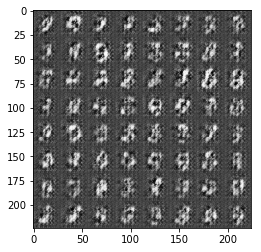

Epoch 1/2... Discriminator Loss: 1.8004... Generator Loss: 5.3804
Epoch 1/2... Discriminator Loss: 0.3812... Generator Loss: 1.5492
Epoch 1/2... Discriminator Loss: 0.6210... Generator Loss: 1.1475
Epoch 1/2... Discriminator Loss: 0.9306... Generator Loss: 0.7752
Epoch 1/2... Discriminator Loss: 0.5329... Generator Loss: 1.1597
Epoch 1/2... Discriminator Loss: 0.1894... Generator Loss: 2.7911
Epoch 1/2... Discriminator Loss: 3.3292... Generator Loss: 0.0711
Epoch 1/2... Discriminator Loss: 0.6959... Generator Loss: 1.1287
Epoch 1/2... Discriminator Loss: 0.5815... Generator Loss: 1.2795
Epoch 1/2... Discriminator Loss: 0.3175... Generator Loss: 2.0522


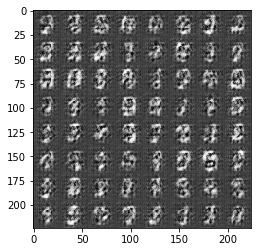

Epoch 1/2... Discriminator Loss: 0.5044... Generator Loss: 1.1387
Epoch 1/2... Discriminator Loss: 0.2430... Generator Loss: 2.0278
Epoch 1/2... Discriminator Loss: 0.2539... Generator Loss: 1.8673
Epoch 1/2... Discriminator Loss: 0.2798... Generator Loss: 1.9496
Epoch 1/2... Discriminator Loss: 0.4758... Generator Loss: 1.4377
Epoch 1/2... Discriminator Loss: 0.2377... Generator Loss: 2.5448
Epoch 1/2... Discriminator Loss: 2.7342... Generator Loss: 0.2276
Epoch 1/2... Discriminator Loss: 0.5619... Generator Loss: 2.0454
Epoch 1/2... Discriminator Loss: 0.6645... Generator Loss: 1.2255
Epoch 1/2... Discriminator Loss: 2.3373... Generator Loss: 0.1263


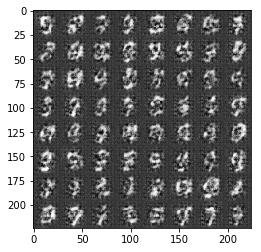

Epoch 1/2... Discriminator Loss: 0.6299... Generator Loss: 1.2109
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 1.4803
Epoch 1/2... Discriminator Loss: 0.1916... Generator Loss: 3.3967
Epoch 1/2... Discriminator Loss: 0.1938... Generator Loss: 2.5282
Epoch 1/2... Discriminator Loss: 0.2622... Generator Loss: 1.7961
Epoch 1/2... Discriminator Loss: 0.6133... Generator Loss: 0.9370
Epoch 1/2... Discriminator Loss: 0.3655... Generator Loss: 1.5496
Epoch 1/2... Discriminator Loss: 0.1037... Generator Loss: 2.6154
Epoch 1/2... Discriminator Loss: 0.0440... Generator Loss: 4.2490
Epoch 1/2... Discriminator Loss: 0.1151... Generator Loss: 2.5667


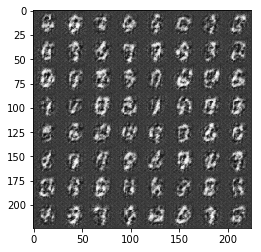

Epoch 1/2... Discriminator Loss: 0.2262... Generator Loss: 2.0008
Epoch 1/2... Discriminator Loss: 0.2505... Generator Loss: 1.7197
Epoch 1/2... Discriminator Loss: 0.1906... Generator Loss: 2.6147
Epoch 1/2... Discriminator Loss: 0.1019... Generator Loss: 2.7642
Epoch 1/2... Discriminator Loss: 0.0736... Generator Loss: 3.0450
Epoch 1/2... Discriminator Loss: 0.1518... Generator Loss: 2.5025
Epoch 1/2... Discriminator Loss: 0.1659... Generator Loss: 2.7221
Epoch 1/2... Discriminator Loss: 0.1259... Generator Loss: 2.6766
Epoch 1/2... Discriminator Loss: 0.0164... Generator Loss: 5.0314
Epoch 1/2... Discriminator Loss: 0.3016... Generator Loss: 2.1490


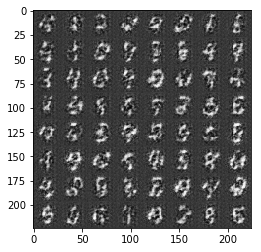

Epoch 1/2... Discriminator Loss: 0.3764... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 4.7828... Generator Loss: 5.3032
Epoch 1/2... Discriminator Loss: 0.6719... Generator Loss: 1.9443
Epoch 1/2... Discriminator Loss: 0.8251... Generator Loss: 3.1335
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 1.0500
Epoch 1/2... Discriminator Loss: 0.5309... Generator Loss: 1.0632
Epoch 1/2... Discriminator Loss: 0.4986... Generator Loss: 3.0720
Epoch 1/2... Discriminator Loss: 0.2979... Generator Loss: 1.7868
Epoch 1/2... Discriminator Loss: 0.1172... Generator Loss: 3.4326
Epoch 1/2... Discriminator Loss: 3.0760... Generator Loss: 0.1299


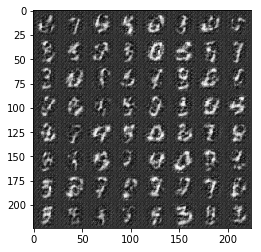

Epoch 1/2... Discriminator Loss: 0.3506... Generator Loss: 2.1577
Epoch 1/2... Discriminator Loss: 0.3569... Generator Loss: 2.3516
Epoch 1/2... Discriminator Loss: 0.5472... Generator Loss: 1.0869
Epoch 1/2... Discriminator Loss: 0.4116... Generator Loss: 1.2751
Epoch 1/2... Discriminator Loss: 1.5379... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 0.2864... Generator Loss: 1.9405
Epoch 1/2... Discriminator Loss: 0.6360... Generator Loss: 1.0646
Epoch 1/2... Discriminator Loss: 0.1705... Generator Loss: 2.9370
Epoch 1/2... Discriminator Loss: 0.3306... Generator Loss: 1.5409
Epoch 1/2... Discriminator Loss: 0.2856... Generator Loss: 1.7773


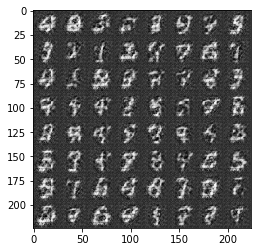

Epoch 1/2... Discriminator Loss: 0.3768... Generator Loss: 1.4623
Epoch 1/2... Discriminator Loss: 1.0358... Generator Loss: 0.5645
Epoch 1/2... Discriminator Loss: 1.9585... Generator Loss: 0.1923
Epoch 1/2... Discriminator Loss: 0.1577... Generator Loss: 2.4988
Epoch 1/2... Discriminator Loss: 0.1089... Generator Loss: 3.0193
Epoch 1/2... Discriminator Loss: 0.4339... Generator Loss: 1.3298
Epoch 1/2... Discriminator Loss: 0.2916... Generator Loss: 3.4447
Epoch 1/2... Discriminator Loss: 0.1045... Generator Loss: 2.6512
Epoch 1/2... Discriminator Loss: 0.2943... Generator Loss: 1.7331
Epoch 1/2... Discriminator Loss: 0.1674... Generator Loss: 2.3843


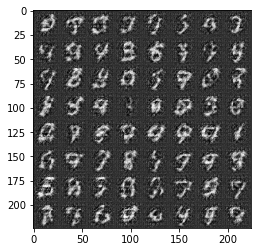

Epoch 1/2... Discriminator Loss: 0.4005... Generator Loss: 1.4649
Epoch 1/2... Discriminator Loss: 0.1470... Generator Loss: 2.3153
Epoch 1/2... Discriminator Loss: 0.2343... Generator Loss: 2.0272
Epoch 1/2... Discriminator Loss: 0.1864... Generator Loss: 2.1610
Epoch 1/2... Discriminator Loss: 0.7519... Generator Loss: 0.9564
Epoch 1/2... Discriminator Loss: 0.0929... Generator Loss: 3.6340
Epoch 1/2... Discriminator Loss: 0.2859... Generator Loss: 4.6170
Epoch 1/2... Discriminator Loss: 0.0747... Generator Loss: 4.1071
Epoch 1/2... Discriminator Loss: 0.2628... Generator Loss: 1.7893
Epoch 1/2... Discriminator Loss: 0.1481... Generator Loss: 2.8949


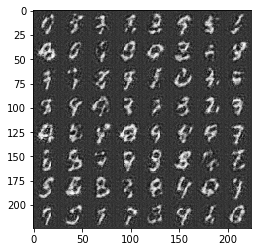

Epoch 1/2... Discriminator Loss: 0.0617... Generator Loss: 3.3685
Epoch 1/2... Discriminator Loss: 0.1044... Generator Loss: 2.5810
Epoch 1/2... Discriminator Loss: 0.0702... Generator Loss: 3.7600
Epoch 1/2... Discriminator Loss: 0.0253... Generator Loss: 4.0639
Epoch 1/2... Discriminator Loss: 1.9130... Generator Loss: 2.5867
Epoch 1/2... Discriminator Loss: 0.4202... Generator Loss: 1.4751
Epoch 1/2... Discriminator Loss: 0.2251... Generator Loss: 2.9496
Epoch 1/2... Discriminator Loss: 0.3195... Generator Loss: 1.8405
Epoch 1/2... Discriminator Loss: 7.2222... Generator Loss: 9.9189
Epoch 1/2... Discriminator Loss: 0.3405... Generator Loss: 1.9543


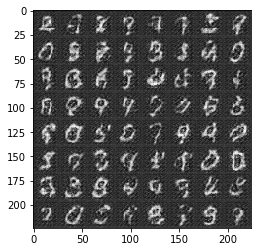

Epoch 1/2... Discriminator Loss: 0.3390... Generator Loss: 1.6428
Epoch 1/2... Discriminator Loss: 0.2123... Generator Loss: 2.1703
Epoch 1/2... Discriminator Loss: 0.1568... Generator Loss: 2.6675
Epoch 1/2... Discriminator Loss: 0.7374... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 0.4878... Generator Loss: 1.1513
Epoch 1/2... Discriminator Loss: 0.2851... Generator Loss: 1.6593
Epoch 1/2... Discriminator Loss: 0.5523... Generator Loss: 1.1806
Epoch 1/2... Discriminator Loss: 0.3046... Generator Loss: 1.6885
Epoch 1/2... Discriminator Loss: 2.2153... Generator Loss: 7.3809
Epoch 1/2... Discriminator Loss: 0.9029... Generator Loss: 0.6760


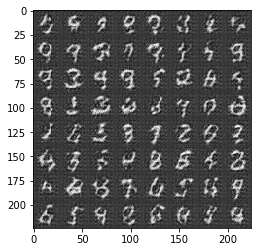

Epoch 1/2... Discriminator Loss: 0.9319... Generator Loss: 0.7247
Epoch 1/2... Discriminator Loss: 0.2096... Generator Loss: 1.9761
Epoch 1/2... Discriminator Loss: 0.4793... Generator Loss: 1.3381
Epoch 1/2... Discriminator Loss: 0.8781... Generator Loss: 0.7074
Epoch 1/2... Discriminator Loss: 0.2872... Generator Loss: 1.8858
Epoch 1/2... Discriminator Loss: 0.1147... Generator Loss: 2.5443
Epoch 1/2... Discriminator Loss: 0.1501... Generator Loss: 2.4604
Epoch 1/2... Discriminator Loss: 0.2088... Generator Loss: 1.9927
Epoch 1/2... Discriminator Loss: 0.4018... Generator Loss: 1.2553
Epoch 1/2... Discriminator Loss: 0.1267... Generator Loss: 2.7557


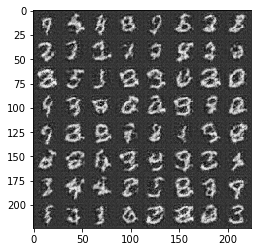

Epoch 1/2... Discriminator Loss: 0.0348... Generator Loss: 4.0537
Epoch 1/2... Discriminator Loss: 0.2688... Generator Loss: 1.8217
Epoch 1/2... Discriminator Loss: 0.1005... Generator Loss: 2.8384
Epoch 1/2... Discriminator Loss: 0.1367... Generator Loss: 2.3858
Epoch 1/2... Discriminator Loss: 0.0691... Generator Loss: 3.1568
Epoch 1/2... Discriminator Loss: 0.0580... Generator Loss: 3.6054
Epoch 1/2... Discriminator Loss: 0.0162... Generator Loss: 4.5895
Epoch 1/2... Discriminator Loss: 0.1210... Generator Loss: 2.5382
Epoch 1/2... Discriminator Loss: 0.0241... Generator Loss: 4.4762
Epoch 1/2... Discriminator Loss: 2.2083... Generator Loss: 4.3184


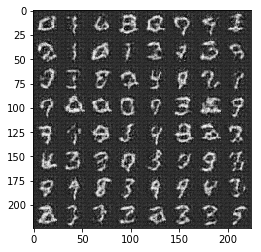

Epoch 1/2... Discriminator Loss: 0.2859... Generator Loss: 2.8274
Epoch 1/2... Discriminator Loss: 0.7466... Generator Loss: 0.8510
Epoch 1/2... Discriminator Loss: 0.1554... Generator Loss: 2.4494
Epoch 1/2... Discriminator Loss: 0.2770... Generator Loss: 1.9095
Epoch 1/2... Discriminator Loss: 0.3137... Generator Loss: 1.6811
Epoch 1/2... Discriminator Loss: 0.0376... Generator Loss: 3.8911
Epoch 1/2... Discriminator Loss: 0.1487... Generator Loss: 2.1691
Epoch 1/2... Discriminator Loss: 0.0338... Generator Loss: 4.0100
Epoch 1/2... Discriminator Loss: 0.0584... Generator Loss: 3.4916
Epoch 1/2... Discriminator Loss: 0.1385... Generator Loss: 2.3906


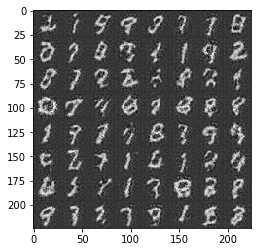

Epoch 1/2... Discriminator Loss: 0.1654... Generator Loss: 2.1088
Epoch 1/2... Discriminator Loss: 0.1278... Generator Loss: 2.7616
Epoch 1/2... Discriminator Loss: 0.2139... Generator Loss: 1.9573
Epoch 1/2... Discriminator Loss: 0.4377... Generator Loss: 1.8872
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.6702
Epoch 1/2... Discriminator Loss: 3.0836... Generator Loss: 0.0723
Epoch 1/2... Discriminator Loss: 0.8583... Generator Loss: 0.7439
Epoch 1/2... Discriminator Loss: 0.6134... Generator Loss: 1.0401
Epoch 1/2... Discriminator Loss: 0.1374... Generator Loss: 2.3843
Epoch 1/2... Discriminator Loss: 0.1005... Generator Loss: 2.7218


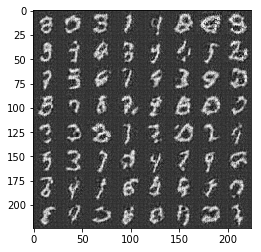

Epoch 1/2... Discriminator Loss: 0.1638... Generator Loss: 2.3212
Epoch 1/2... Discriminator Loss: 0.1126... Generator Loss: 3.7314
Epoch 1/2... Discriminator Loss: 0.1247... Generator Loss: 3.4816
Epoch 1/2... Discriminator Loss: 0.2263... Generator Loss: 1.8751
Epoch 1/2... Discriminator Loss: 0.2088... Generator Loss: 1.9337
Epoch 1/2... Discriminator Loss: 0.2282... Generator Loss: 1.9030
Epoch 1/2... Discriminator Loss: 0.1280... Generator Loss: 2.2497
Epoch 1/2... Discriminator Loss: 0.1497... Generator Loss: 2.3120
Epoch 1/2... Discriminator Loss: 0.0323... Generator Loss: 3.7293
Epoch 1/2... Discriminator Loss: 0.2093... Generator Loss: 1.8870


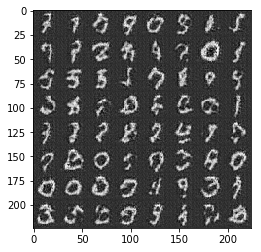

Epoch 1/2... Discriminator Loss: 0.0237... Generator Loss: 4.2584
Epoch 1/2... Discriminator Loss: 0.2466... Generator Loss: 1.9895
Epoch 1/2... Discriminator Loss: 0.2721... Generator Loss: 1.7084
Epoch 1/2... Discriminator Loss: 0.0407... Generator Loss: 3.6825
Epoch 1/2... Discriminator Loss: 0.0161... Generator Loss: 4.7912
Epoch 1/2... Discriminator Loss: 0.1602... Generator Loss: 2.5415
Epoch 1/2... Discriminator Loss: 0.1858... Generator Loss: 2.0447
Epoch 1/2... Discriminator Loss: 0.0153... Generator Loss: 5.2440
Epoch 1/2... Discriminator Loss: 0.0620... Generator Loss: 3.5733
Epoch 1/2... Discriminator Loss: 0.0153... Generator Loss: 5.1680


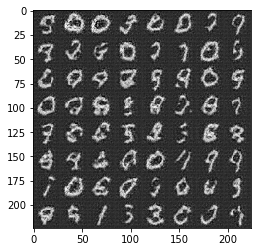

Epoch 1/2... Discriminator Loss: 0.0388... Generator Loss: 3.9914
Epoch 1/2... Discriminator Loss: 0.0686... Generator Loss: 3.4516
Epoch 1/2... Discriminator Loss: 0.1629... Generator Loss: 2.3143
Epoch 1/2... Discriminator Loss: 0.0314... Generator Loss: 4.3463
Epoch 1/2... Discriminator Loss: 0.1037... Generator Loss: 2.6345
Epoch 1/2... Discriminator Loss: 0.0186... Generator Loss: 4.7128
Epoch 1/2... Discriminator Loss: 0.1091... Generator Loss: 2.8784
Epoch 1/2... Discriminator Loss: 17.0041... Generator Loss: 18.1275
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.5566
Epoch 1/2... Discriminator Loss: 0.7622... Generator Loss: 1.2872


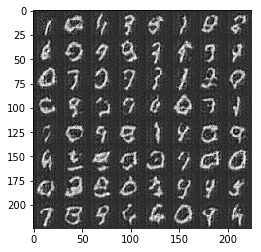

Epoch 1/2... Discriminator Loss: 1.1611... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 0.5282... Generator Loss: 1.3994
Epoch 1/2... Discriminator Loss: 0.6457... Generator Loss: 2.0650
Epoch 1/2... Discriminator Loss: 0.7643... Generator Loss: 2.9880
Epoch 1/2... Discriminator Loss: 0.9467... Generator Loss: 3.3769
Epoch 1/2... Discriminator Loss: 2.3583... Generator Loss: 0.1265
Epoch 1/2... Discriminator Loss: 0.3178... Generator Loss: 2.7378
Epoch 1/2... Discriminator Loss: 0.3285... Generator Loss: 2.3220
Epoch 1/2... Discriminator Loss: 0.5297... Generator Loss: 1.4610
Epoch 1/2... Discriminator Loss: 0.3710... Generator Loss: 1.8275


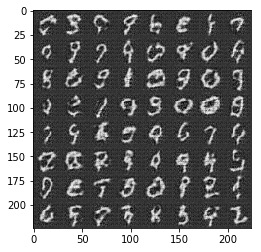

Epoch 1/2... Discriminator Loss: 0.3629... Generator Loss: 3.2078
Epoch 1/2... Discriminator Loss: 0.4078... Generator Loss: 1.9715
Epoch 1/2... Discriminator Loss: 1.1163... Generator Loss: 4.5458
Epoch 1/2... Discriminator Loss: 0.1803... Generator Loss: 3.1965
Epoch 1/2... Discriminator Loss: 0.4198... Generator Loss: 2.2906
Epoch 1/2... Discriminator Loss: 0.2716... Generator Loss: 2.2827
Epoch 1/2... Discriminator Loss: 0.5694... Generator Loss: 1.7024
Epoch 1/2... Discriminator Loss: 0.5880... Generator Loss: 1.1711
Epoch 1/2... Discriminator Loss: 0.2765... Generator Loss: 2.5936
Epoch 1/2... Discriminator Loss: 0.2396... Generator Loss: 1.9125


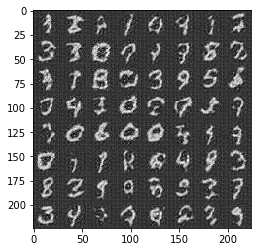

Epoch 1/2... Discriminator Loss: 0.2714... Generator Loss: 1.6537
Epoch 1/2... Discriminator Loss: 0.3944... Generator Loss: 1.5750
Epoch 1/2... Discriminator Loss: 0.5799... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 0.4876... Generator Loss: 3.9530
Epoch 1/2... Discriminator Loss: 0.1841... Generator Loss: 2.5642
Epoch 1/2... Discriminator Loss: 1.6738... Generator Loss: 0.3754
Epoch 1/2... Discriminator Loss: 0.3639... Generator Loss: 2.6418
Epoch 1/2... Discriminator Loss: 0.3692... Generator Loss: 1.9439
Epoch 1/2... Discriminator Loss: 0.4058... Generator Loss: 1.3289
Epoch 1/2... Discriminator Loss: 0.9761... Generator Loss: 0.6841


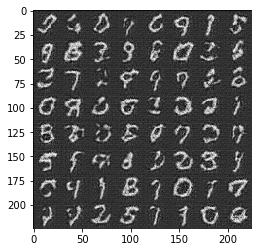

Epoch 1/2... Discriminator Loss: 0.3157... Generator Loss: 1.6338
Epoch 1/2... Discriminator Loss: 0.1991... Generator Loss: 2.7813
Epoch 1/2... Discriminator Loss: 0.2816... Generator Loss: 1.7165
Epoch 1/2... Discriminator Loss: 0.3920... Generator Loss: 1.4410
Epoch 1/2... Discriminator Loss: 0.4848... Generator Loss: 1.3194


In [ ]:
batch_size = 10
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 10
z_dim = 50
learning_rate = 0.0005
beta1 = 0.5

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.